In [7]:
import level1,level2,analysis,plottools,inversions
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.basemap import Basemap
import netCDF4 as nc
import datetime as dt
import scipy.stats as stats
import numpy.ma as ma
from mpl_toolkits.mplot3d import Axes3D

In [9]:
# Data
eddies = np.load('../eddies_last.npy').item()
ADCPs = np.load('../ADCPS.npy').item()

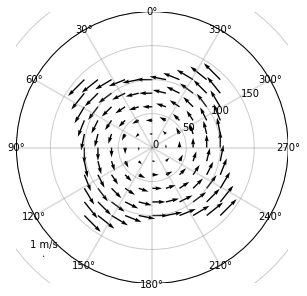

In [3]:
#simulate a whole eddy
xm = np.arange(-100000,101000,20000)
ym = np.arange(-100000,101000,20000)
X,Y = np.meshgrid(xm,ym)
xc = 0
yc = 0
U,V = inversions.Simulate(xc,yc,X,Y,omega=1e-5,fmt='UV')
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1, 1, 1)
plottools.Hodograph(ax,200,xtext=False,ytext=False,grid=50)
# Set axis limits, in order to see circle aspect MUST be set to equal
#ax.set_xlim(-200,200)
#ax.set_ylim(-200,200)
ax.set_aspect('equal')

Q=plt.quiver(xm/1000,ym/1000,U,V,width=0.005,pivot='tail')
plt.quiverkey(Q,0.1,0.1,0.01,label= '1 m/s')
plt.show()

A filter should be applied directly to the data with 3 dimensions

In [18]:
ADCPs.keys()

dict_keys(['V1', 'V3', 'M10_EW', 'M10_SN', 'M10', 'M12'])

In [79]:
ADCP = ADCPs['V1']
lon = ADCP['longitudes']
lat = ADCP['latitudes']
depths = ADCP['depths']
V = ADCP['V']
U = ADCP['U']
deltat = 100
m = Basemap(projection='merc',llcrnrlat = min(lat)-1,urcrnrlat = max(lat)+1,llcrnrlon=min(lon)-1,urcrnrlon=max(lon)+1)
x,y = m(lon,lat)
atd = analysis.ComputeATD(lon,lat,m=m)

In [81]:
V_filt = analysis.BoxCarFilter2(V,x,y,depths,40e3,40e3,150)
U_filt = analysis.BoxCarFilter2(U,x,y,depths,40e3,40e3,150)

/home/affholder/Documents/ENS/AFC/Stage/Araujo/Eddie_Tracks/Scripts/ADCP/analysis.py:231: RuntimeWarning: Mean of empty slice
  val = np.nanmean(Mf[indexes])


In [82]:
X = []
Y = []
Z = []
# Vl = []
for i in range(len(x)):
    for j in range(len(depths)):
        X.append(x[i])
        Y.append(y[i])
        Z.append(depths[j])
#         Vl.append(V[i,j])
X = np.array(X)
Y = np.array(Y)
Z = np.array(Z)
# Vl = np.array(Vl)
Vlf = V_filt.flatten()

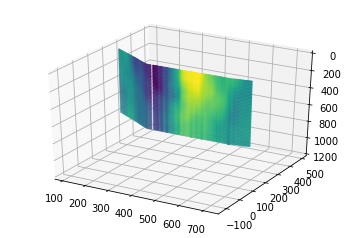

In [83]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# ax.set_yticks(np.arange(100,250,10))
# ax.set_xticks(np.arange(100,700,10))
# ax.set_xlim(100,700)
# ax.set_ylim(100,250)
ax.set_zlim(1200,0)
s = ax.scatter(X/1000,Y/1000,Z,c=Vlf,s=0.8)
# Create cubic bounding box to simulate equal aspect ratio
max_range = np.array([X.max()-X.min(), Y.max()-Y.min()]).max()
Xb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][0].flatten() + 0.5*(X.max()+X.min())
Yb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][1].flatten() + 0.5*(Y.max()+Y.min())
# Comment or uncomment following both lines to test the fake bounding box:
for xb, yb in zip(Xb, Yb):
    ax.plot([xb/1000], [yb/1000], [0], 'w')

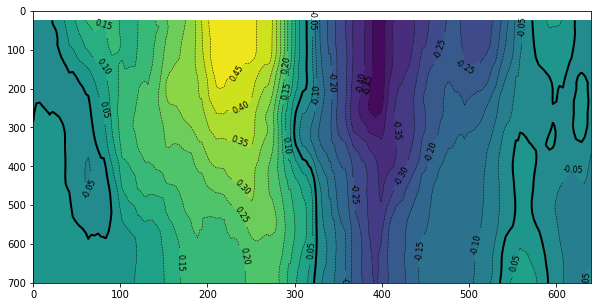

In [85]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)
ax.set_ylim(700,0)
plottools.PlotADCP(ax,atd,depths,V_filt)
plt.show()

In [86]:
Rvals = []
Pvals = []
Omegas = []
Coeffs = []
Zeros = []
for i in range(len(depths)):
    um = U_filt[:,i]
    vm = V_filt[:,i]
    size,rval,pval,omega,coeffs,zero = inversions.SBExtension(vm,atd,deltat)
#     Sizes.append(size)
    Rvals.append(rval)
    Pvals.append(pval)
    Omegas.append(omega)
    Coeffs.append(coeffs)
    Zeros.append(zero)
# Sizes = np.array(size)
Rvals = np.array(Rvals)
Pvals = np.array(Pvals)
Omegas = np.array(Omegas)
# Coeffs = np.array(Coeffs)
Zeros = np.array(Zeros)

/usr/local/lib/python3.6/dist-packages/scipy/stats/_stats_mstats_common.py:107: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/usr/local/lib/python3.6/dist-packages/scipy/stats/_stats_mstats_common.py:117: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/usr/local/lib/python3.6/dist-packages/scipy/stats/_stats_mstats_common.py:119: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


In [87]:
plus = np.array([Zeros[i] + size for i in range(len(depths))])
moins = np.array([Zeros[i] - size for i in range(len(depths))])
moins = np.fliplr(moins)
faisceau = np.append(moins,plus,axis=1)
ZZ2 = np.repeat(depths,len(size)*2).reshape((len(depths),len(size)*2))
slavR = np.fliplr(Rvals)
Rvals_sim = np.append(slavR,Rvals,axis=1)
slavP = np.fliplr(Pvals)
Pvals_sim = np.append(slavP,Pvals,axis=1)
# Rvals_sim = ma.masked_where(Pvals_sim > 0.05,Rvals_sim)

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


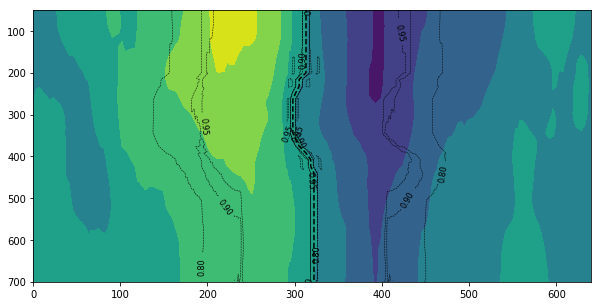

In [89]:
XX,ZZ = np.meshgrid(atd/1000,depths)

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)
ax.set_ylim(700,50)
ax.contourf(XX,ZZ,np.transpose(V_filt))
ax.plot(Zeros/1000,depths,'k--',linewidth = 1.5)
levels = [0.8,0.9,0.95]
cont = ax.contour(faisceau/1000,ZZ2,Rvals_sim,linestyles='dashed',colors='k',linewidths=0.5,levels=levels)
ax.clabel(cont, fontsize=8, inline=1, fmt='%1.2f')
# ax.plot(faisceau[np.where(Pvals_sim>0.05)]/1000,ZZ2[np.where(Pvals_sim>0.05)],'k+',ms=2)
plt.show()

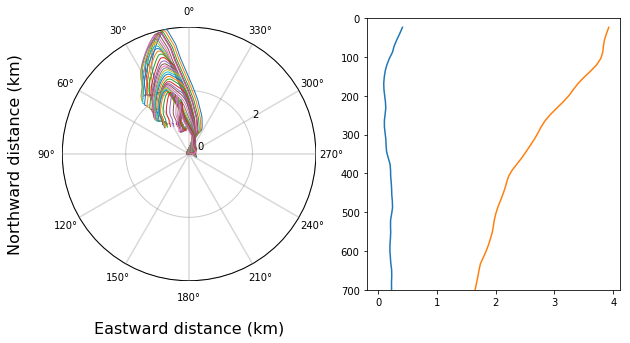

In [91]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
plottools.Hodograph(ax,4)

uampl = []
vampl = []
for i in range(len(depths)):
    u = U_filt[:,i]
    v = V_filt[:,i]
    ix = (np.nancumsum(u)*deltat)/1000
    iy = (np.nancumsum(v)*deltat)/1000
    ax.plot(ix,iy,linewidth=1)
    umax = np.nanmax(ix)
    vmax = np.nanmax(iy)
    uampl.append(umax)
    vampl.append(vmax)
ax2.set_ylim(700,0)
ax2.plot(uampl,depths)
ax2.plot(vampl,depths)
# plottools.PlotHodograph(ax,U_filt[:,1],V_filt[:,1],deltat)
plt.show()

In [92]:
angles_m = np.angle(U_filt + V_filt*1j)
cos_m = np.cos(angles_m)
sin_m = np.sin(angles_m)

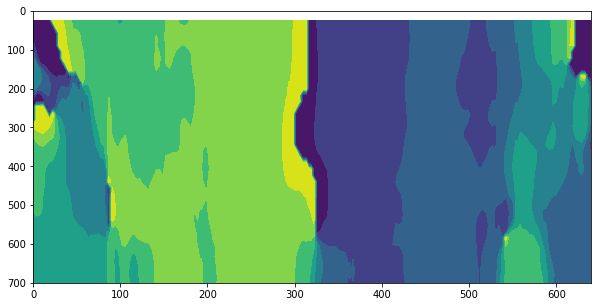

In [93]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)
ax.set_ylim(700,0)
xx,zz = np.meshgrid(atd/1000,depths)
ax.contourf(xx,zz,np.transpose(angles_m))
plt.show()

In [94]:
def Err(xc,yc,xm,ym,cos_m,sin_m):
    angles_s,norms_s = inversions.Simulate(xc,yc,x,y,omega=1e-5,fmt='AN')
    cos_s = np.cos(angles_s)
    sin_s = np.sin(angles_s)
    rr = np.sqrt((sin_m - sin_s)**2 + (cos_m - cos_s)**2)/np.sqrt(2*len(angles_s))
    return(rr)

In [99]:
xplore = np.arange(300,500,1)*1e3
yplore = np.arange(50,150,1)*1e3
# sMerr = np.full((len(xplore),len(yplore)),np.nan)
# cMerr = np.full((len(xplore),len(yplore)),np.nan)
Merr = np.full((len(xplore),len(yplore)),np.nan)
for i in range(len(xplore)):
    for j in range(len(yplore)):
        xi = xplore[i]
        yj = yplore[j]
        rr = Err(xi,yj,x,y,cos_m[:,3],sin_m[:,3])
        val = np.nansum(rr)
        Merr[i,j] = val
#         angles_s,norms_s = inversions.Simulate(xi,yj,x,y,omega=1e-5,fmt='AN')
#         cos_s = np.cos(angles_s)
#         sin_s = np.sin(angles_s)
#         srr = np.nansum(np.sqrt((sin_m[:,3] - sin_s)**2)/np.sqrt(2*len(angles_s)))
#         crr = np.nansum(np.sqrt((cos_m[:,3] - cos_s)**2)/np.sqrt(2*len(angles_s)))
#         sMerr[i,j] = srr
#         cMerr[i,j] = crr

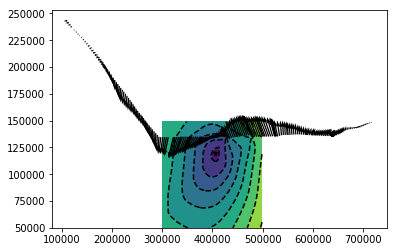

In [100]:
Xp,Yp = np.meshgrid(xplore,yplore)
M = np.transpose(Merr)
# plt.plot(x,y)
plt.contourf(Xp,Yp,M)
cont = plt.contour(Xp,Yp,M,linestyles='dashed',colors='k')
plt.plot(Xp[M==np.nanmin(M)],Yp[M==np.nanmin(M)],'k*',ms=5)
plt.quiver(x,y,U_filt[:,3],V_filt[:,3],pivot='tail')

In [101]:
xc = Xp[M==np.nanmin(M)][0]
yc = Yp[M==np.nanmin(M)][0]
angles_s,norms_s = inversions.Simulate(xc,yc,x,y,omega=1e-5,fmt='AN')
cos_s = np.cos(angles_s)
sin_s = np.sin(angles_s)

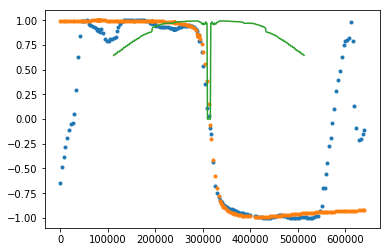

In [120]:
plt.plot(atd,sin_m[:,3],'.')
plt.plot(atd,sin_s,'.')
plt.plot(faisceau[3,:],Rvals_sim[3,:])

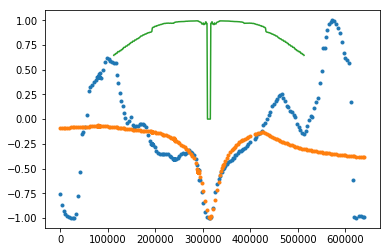

In [118]:
plt.plot(atd,cos_m[:,3],'.')
plt.plot(atd,cos_s,'.')
plt.plot(faisceau[3,:],Rvals_sim[3,:])

In [127]:
np.where(Rvals_sim[3,:] == np.nanmin(Rvals_sim[3,Rvals_sim[3,:] > 0.75]))

(array([ 30,  31,  32, 367, 368, 369]),)

In [129]:
min(faisceau[3,Rvals_sim[3,:] > 0.75])

143010.87345171423

In [130]:
max(faisceau[3,Rvals_sim[3,:] > 0.75])

483010.87345171423

In [151]:
## Extract solid body from the data
indexes_x = []
indexes_z = []
for i in range(len(depths)):
    faisc = faisceau[i,Rvals_sim[i,:] > 0.75]
    if len(faisc) > 0:
        atd_inf = np.nanmin(faisc)
        atd_sup = np.nanmax(faisc)
        indexes_to_mask = np.where((atd < atd_inf)+(atd > atd_sup))[0]
        dindex = [i]*len(indexes_to_mask)
        indexes_x.append(indexes_to_mask)
        indexes_z.append(dindex)
indexes = (np.array(indexes_x).flatten(),np.array(indexes_z).flatten())
    

/usr/lib/python3/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """


In [152]:
indexes

(array([array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217,
        218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230,
        231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243,
        244, 245, 246, 247, 248, 249, 250]),
        array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  6

In [148]:
faisc = faisceau[3,Rvals_sim[3,:] > 0.75]
inf = np.nanmin(faisc)
sup = np.nanmax(faisc)
(atd < inf)+(atd > sup)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

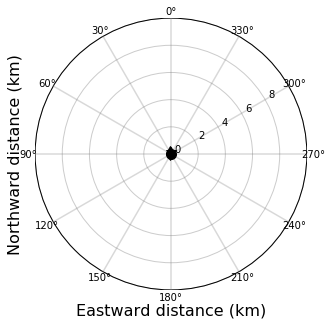

In [104]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)
deltat = 1
plottools.Hodograph(ax,10)
#plottools.PlotHodograph(ax,cos_m,sin_m,deltat,legend=False)
plottools.PlotHodograph(ax,cos_s,sin_s,deltat,legend=False)

In [105]:
np.nancumsum(cos_m)*60

array([  -53.59648701,  -106.25125088,  -155.54308533, ...,
       31119.32102867, 31119.32102867, 31119.32102867])

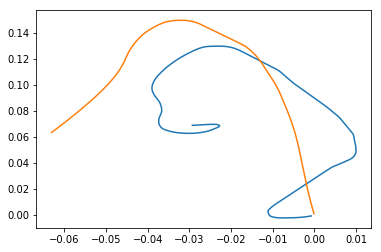

In [106]:
plt.plot(np.nancumsum(cos_m[:,3])/1000,np.nancumsum(sin_m[:,3])/1000)
plt.plot(np.nancumsum(cos_s)/1000,np.nancumsum(sin_s)/1000)